# Bias-Variance trade-off (practice, my notes)

En esta colab notebook vamos a explorar los conceptos teóricos previamente expuestos con un "toy example".
¿Por qué un "toy example" y no data real?

En la práctica, nunca vamos a conocer el verdadero proceso que genera los datos (si lo conocieramos, no necesitaríamos utilizar técnicas de machine learning). El valor de simular ese proceso, es que nos va permitir conocer exactamente su distribución y eso nos va ayudar a entender que tan buenas son nuestras estimaciones y mejorar nuestra intuición sobre los distintos conceptos y métodos


In [1]:
%%capture
%run ./001_dataset-regression.ipynb

## Average function (from samples)

In [2]:
def average_f(X: np.array,Y: np.array,a: float,b: float):
    """
    Given datasets with samples computes the average function.
    X: matrix of x with shape (datasets,samples)
    Y: matrix of y with shape (datasets,samples)
    a: min x range
    b: max x range  

    """
    assert X.shape == Y.shape
    
    datasets, samples = X.shape  

    fs = [interp1d(X[i,:], Y[i,:],'linear',bounds_error=False) for i in range(datasets)]  

    # define common carrier for calculation of average curve
    x_all = np.linspace(a,b, num=101)
    
    # evaluation of fits on common carrier
    f_ints = [f(x_all) for f in fs]  

    # put all fits to one matrix for fast mean calculation
    data_collection = np.vstack(f_ints)  

    # calculating mean value
    f_avg_points = np.average(data_collection, axis=0)  

    f_avg = interp1d(x_all,f_avg_points,bounds_error=False)  

    return f_avg_points , f_avg

In [3]:
#f_avg_points , f_avg = average_f(x_datasets,y_datasets_w_noise,a,b)
#plt.scatter(np.linspace(0, 10, num=101),f_avg_points,color='orange')
#plt.plot(true_f_x,true_f_y)

## Plot Bias Variance

In [4]:
def plot_bias_variance(fig,ax, x_datasets,preds,h_avg,y_datasets_w_noise,f_avg):
    x_domain = np.linspace(0, 10, num=101)  
    
    ax.scatter(x_datasets.ravel(),preds.ravel(),alpha=0.1,color='orange')
    ax.plot(x_domain,h_avg(x_domain),color='orange')
    ax.scatter(x_datasets.ravel(),y_datasets_w_noise.ravel(),alpha=0.1,color='blue')
    ax.plot(x_domain,f_avg(x_domain),color='violet')  

    #return fig, ax

In [5]:
#fig , ax = plot_bias_variance(x_datasets,preds,h_avg,y_datasets_w_noise,f_avg)

\begin{align*}
\underbrace{ \mathbb{E}_{\mathbb{x},y,D} \Big[{(h_D(\mathbb{x})−y)}^2 \Big] }_{\text{Expected Test Error}}= \underbrace{\mathbb{E}_{\mathbb{x},D} \Big[ {(h_D(\mathbb{x})−\bar{h}(\mathbb{x}))}^2\Big]}_{\text{Variance}} + \underbrace{ \mathbb{E}_{\mathbb{x}} \Big[{(\bar{h}(\mathbb{x})−\bar{y}(\mathbb{x}))}^2\Big] }_{\text{Bias}^2} + \underbrace{ \mathbb{E}_{\mathbb{x},y}\Big[(\bar{y}(x)−y)^2\Big] }_{\text{Noise}}
\end{align*}

In [6]:
def avg_square_diff(a,b,sel=None):
    """
    Average square difference between two tensors with same shape
    """
    a.shape == b.shape
    if sel is None:
      sel = np.ones(a.shape, dtype=bool).ravel()
    return np.nanmean((a.ravel()[sel] - b.ravel()[sel] )**2)

In [7]:
def compute_error_decomposition_test(d,x_test,preds_test,h_avg,f_avg,y_test_w_noise,x_min,x_max):
    sel = (np.tile(x_test,(d,1)).ravel() > x_min) & ((np.tile(x_test,(d,1)).ravel() < x_max))
    variance = avg_square_diff(preds_test,h_avg(np.tile(x_test,(d,1))),sel)
  
    sel = (x_test.ravel() > x_min) & (x_test.ravel() < x_max)
    bias2 = avg_square_diff(h_avg(x_test),f_avg(x_test),sel)
    noise = avg_square_diff(f_avg(x_test),y_test_w_noise,sel)

    sel = (np.tile(x_test,(d,1)).ravel() > x_min) & ((np.tile(x_test,(d,1)).ravel() < x_max))
    test_error = avg_square_diff(preds_test,np.tile(y_test_w_noise,(d,1)),sel)
    return {"test_error":test_error,"variance":variance,"bias2":bias2,"noise":noise}

In [8]:
def display_result(test_error,variance,bias2,noise):
    res = f"Test Error: {test_error} = Variance: {variance} + Bias^2: {bias2} + Noise: {noise} \n {test_error} = {variance + bias2 + noise}"
    print(res)

In [9]:
#display_result(**compute_error_decomposition_test(x_test,preds_test,h_avg,y_test_w_noise))

## Train different models and compute metrics

In [10]:
def complexity_analysis(x_datasets,y_datasets_w_noise,x_test,y_test_w_noise,a,b):
    assert x_datasets.shape == y_datasets_w_noise.shape
    # Infer d,n from x_dataset
    d,n = x_datasets.shape  

    #######################################################
    sub_tab=[widgets.Output() for i in range(1,10)]
    tab = widgets.Tab(sub_tab)
    ######################  
    
    results = {}
    for max_depth in range(1,10):
        models = []
        preds = np.zeros([d,n])
        for i in range(d):
            reg = tree.DecisionTreeRegressor(max_depth=max_depth).fit(x_datasets[i,:].reshape(-1,1), y_datasets_w_noise[i,:].reshape(-1,1))
            pred = reg.predict(x_datasets[i,:].reshape(-1,1)).ravel()
            models.append(reg)
            preds[i,:] = pred    

        # Use the d models that we train with the training data and make them predict
        # for the test set
        preds_test = np.zeros((d,n_test))
        for i in range(d):
            preds_test[i,:] = models[i].predict(x_test.reshape(-1,1)).ravel()    

        f_avg_points , f_avg = average_f(x_datasets,y_datasets_w_noise,a,b)
        f_avg = np.vectorize(lambda x :  (0.45*x-2)**3 - 0.55*(0.2*x-3)**2-2.5*(0.5*x-3)+ 5) # True function that we would like to learn
        h_avg_points , h_avg = average_f(np.tile(x_test,(d,1)),preds_test,a,b)
        

        tab.set_title(max_depth-1,f"max_depth = {max_depth}")
        with sub_tab[max_depth-1]:
            fig, ax = plt.subplots(figsize = (16,9))
            plot_bias_variance(fig,ax,x_datasets,preds,h_avg,y_datasets_w_noise,f_avg)
            plt.show(fig)

        x_min = a
        x_max = b
        results[max_depth] = {"plot":(fig,ax),"values":compute_error_decomposition_test(d,x_test,preds_test,h_avg,f_avg,y_test_w_noise,x_min,x_max)}
    
    display(tab)
    return results

In [11]:
def complexity_analysis_results_to_numpy(results):
    """
    Transforms results into a tuple of arrays for plotting.
    results: output of complexity_analysis function
    """
    inds = np.array([i for i,d in results.items()])
    test_errors = np.array([d["values"]["test_error"] for i,d in results.items()])
    vars = np.array([d["values"]["variance"] for i,d in results.items()])
    biases = np.array([d["values"]["bias2"] for i,d in results.items()])
    noises = np.array([d["values"]["noise"] for i,d in results.items()])
    test_errors_min_ind = np.argmin(test_errors)

    return (inds,test_errors,vars,biases,noises,test_errors_min_ind)

In [12]:
def plot_bias_var_to(inds,test_errors,vars,biases,noises,test_errors_min_ind):
    fig, ax = plt.subplots(figsize = (16,9))

    ax.plot(inds,test_errors,label='test error')
    ax.plot(inds[test_errors_min_ind], test_errors[test_errors_min_ind], 'ro', label= 'Minimum Test Error')
    ax.plot(inds,vars,'--',label='variance')
    ax.plot(inds,biases,'--',label='bias')
    ax.plot(inds,noises,'--',label='noise')
    plt.xlabel("Complexity (tree: max_depth)")
    plt.title("Bias-Variance Tradeoff")
    plt.legend()

## Experiment 1

In [13]:
d = 5 # number of training datasets 
n = 100 # samples per training dataset
a, b = 0,10 # x domain range (a,b)
f = np.vectorize(lambda x :  (0.45*x-2)**3 - 0.55*(0.2*x-3)**2-2.5*(0.5*x-3)+ 5) # True function that we would like to learn
var = 0.5 # Noise to add to the true function

d_test = 1 # number of test datasets 
n_test = 20 # samples per test dataset

In [14]:
x_trains, y_trains = generate_datasets(d,n,f,a,b,var)
x_tests, y_tests = generate_datasets(d_test,n_test,f=f,a=a,b=b,var=var)

In [15]:
results = complexity_analysis(x_trains,y_trains,x_tests,y_tests,a,b)

## Experiment 1: Results

Vemos que a medida que el modelo es más complejo:
- El sesgo (bias) se reduce.
- La varianza (variance) aumenta.
- El ruido se mantiene igual.

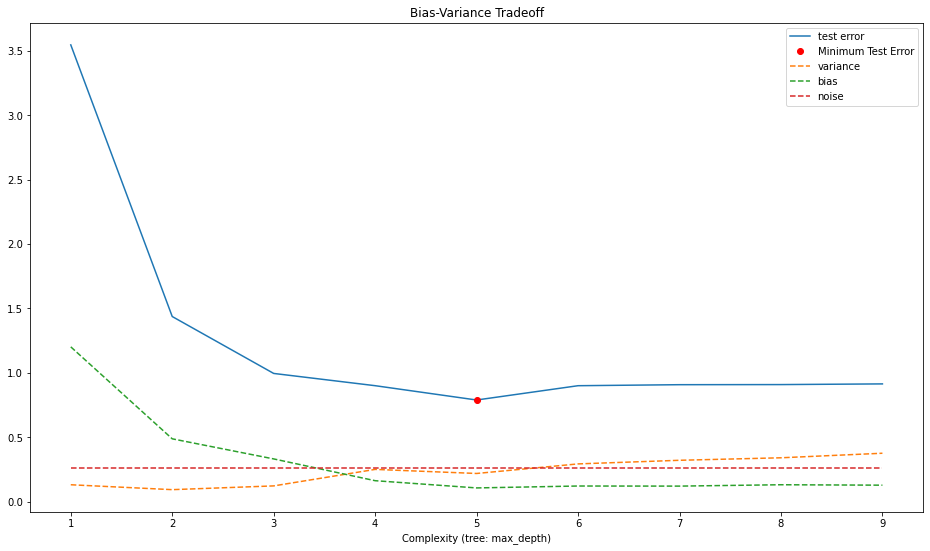

In [16]:
plot_bias_var_to(*complexity_analysis_results_to_numpy(results))

## Experiment 2

Veamos que pasa cuando usamos más data.

In [17]:
d = 5 # number of datasets to create
n = 500 # samples per dataset
a, b = 0,10 # x domain range (a,b)
f = np.vectorize(lambda x :  (0.45*x-2)**3 - 0.55*(0.2*x-3)**2-2.5*(0.5*x-3)+ 5) # True function that we would like to learn
var = 0.5 # Noise to add to the true function

d_test = 1
n_test = 200

In [18]:
x_trains, y_trains = generate_datasets(d,n,f,a,b,var)
x_tests, y_tests = generate_datasets(d_test,n_test,f=f,a=a,b=b,var=var)

In [19]:
results =  complexity_analysis(x_trains,y_trains,x_tests,y_tests,a,b)

## Experiment 2: Results

Vemos que el aumentar la cantidad de nuestros datos, la performance de nuestro modelo mejora (pero el limite a esa mejora es el ruido).

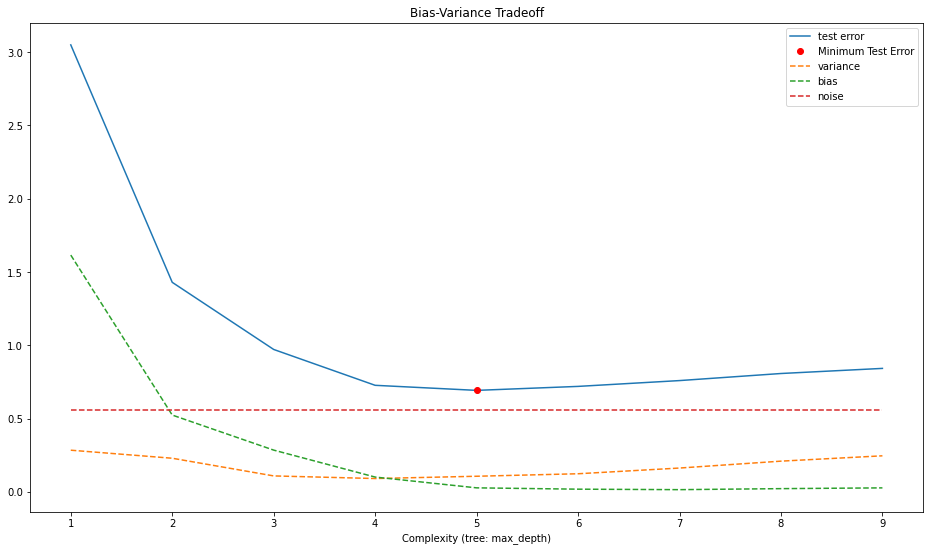

In [20]:
plot_bias_var_to(*complexity_analysis_results_to_numpy(results))

## Other resources

Bias-Variance trade-off with other loss functions and for other problems ( classification)

https://homes.cs.washington.edu/~pedrod/bvd.pdf

https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf

https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf

https://people.eecs.berkeley.edu/~jrs/189s19/lec/12.pdf

http://cs229.stanford.edu/summer2020/BiasVarianceAnalysis.pdf

https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9

## References

```{bibliography} ./references.bib
:filter: docname in docnames
```
